In [2]:
import os
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
# import faiss
# from vendi_score import vendi
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModel
from datasets import load_dataset

scores_path = '/mnt/data/data-selection/data/processed/cohere/scores.jsonl'
data_path = '/mnt/data/data-selection/data/processed/cohere/cohere_data.jsonl'
embedding_cache_path = '/mnt/data/data-selection/data/processed/cohere/Llama-2-7b-hf-tulu_user_only-embeddings.npy'

indices_path = {
    'random': '/mnt/data/data-selection/selection/indices/cohere_Random_0.05_Llama-2-7b-hf.pkl',
    'KMeansRandom_1024': '/mnt/data/data-selection/selection/indices/cohere_KMenasRandomDeita_0.05_Llama-2-7b-hf_1024.pkl',
    'KMeansRandom_64': '/mnt/data/data-selection/selection/indices/cohere_KMenasRandomDeita_0.05_Llama-2-7b-hf_64.pkl',
    'Deita': '/mnt/data/data-selection/selection/indices/cohere_KCenterGreedyDeita_0.05_Llama-2-7b-hf.pkl',
    'KMeansDynamic': '/mnt/data/data-selection/selection/indices/cohere_KMeansDynamic_0.05_Llama-2-7b-hf.pkl',
    'KMeansRandom': '/mnt/data/data-selection/selection/indices/cohere_KMeansRandom_0.05_Llama-2-7b-hf.pkl'
}

/Users/simonyu/opt/anaconda3/envs/robust/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
def safe_softmax(x):
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum()

def cosine_similarity(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [3]:
with open(scores_path) as f:
    scores = [json.loads(l) for l in f]

scores = pd.DataFrame(scores)
embeddings = np.load(embedding_cache_path)

dataset = load_dataset('json', data_files=data_path, field='train')['train']
dataset

embeddings.shape

FileNotFoundError: [Errno 2] No such file or directory: '/mnt/data/data-selection/data/processed/cohere/scores.jsonl'

In [ ]:
with open(scores_path, "r") as f:
    lines = f.readlines()
scores = [json.loads(line)['eval_score'] for line in lines]
eval_scores = np.array(scores, dtype=np.int64)
eval_ranking = np.argsort(scores)[::-1]

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-2-7b-hf")

def encode_messages_and_length(example, tokenizer):
    def _concat_messages(messages):
        message_text = ""
        for message in messages:
            if message["role"] == "system":
                message_text += "<|system|>\n" + message["content"].strip() + "\n"
            elif message["role"] == "user":
                message_text += "<|user|>\n" + message["content"].strip() + "\n"
            elif message["role"] == "assistant":
                message_text += "<|assistant|>\n" + message["content"].strip() + tokenizer.eos_token + "\n"
            else:
                raise ValueError("Invalid role: {}".format(message["role"]))
        return message_text
        
    example_text = _concat_messages(example["messages"])
    # calculate how times <|assistant|> and <|user|> appear in the example
    assistant_count = example_text.count("<|assistant|>")
    user_count = example_text.count("<|user|>")
    tokenized_example = tokenizer(example_text, return_tensors='pt')
    input_ids = tokenized_example.input_ids
    labels = input_ids.clone()

    return {
        'length': len(input_ids.flatten()),
        'user_count': user_count,
        'assistant_count': assistant_count,
    }
dataset = load_dataset('json', data_files=data_path, field='train')['train']
dataset

In [ ]:
import pickle as pkl

index_names = ["Deita", "KMeansDynamic", "KMeansRandom_1024", "random"]
name2indices = {}
name2ziped = {}
for name in index_names:
    with open(indices_path[name], 'rb') as f:
        name2indices[name] = np.array(pkl.load(f)['indices'])

        messages = dataset.select(name2indices[name]).map(lambda x: encode_messages_and_length(x, tokenizer), batched=False)
        length = messages['length']
        scores = list(eval_scores[name2indices[name]])
        ziped = list(zip(length, scores))
        name2ziped[name] = ziped
name2indices

In [ ]:
# test_length = test['length']
# test_scores = list(eval_scores[name2indices['Deita']])
# ziped = list(zip(test_length, test_scores))
# # plot the scatter plot
# plt.scatter(*zip(*ziped))
# plot the scatter plot with different colors for different ziped
for name in ["Deita", "random"]:
    plt.scatter(*zip(*name2ziped[name]), label=name)
# x axis as length, y axis as scores
plt.xlabel('Length')
plt.ylabel('Scores')

plt.legend()
plt.show()

In [ ]:
import pickle as pkl
selected_scores = {}
selected_embeddings = {}
for name, index_path in indices_path.items():
    print(name)
    with open(index_path, 'rb') as f:
        index = pkl.load(f)
    indices = np.array(index['indices'])

    selected_scores[name] = eval_scores[indices]
    selected_embeddings[name] = embeddings[indices]
    print('Score:', np.mean(selected_scores[name]))
    # sample 500 to compute vendi score
    # seeds = [1, 13, 42, 87, 100]
    seeds= [42]
    vendi_scores = []
    for seed in seeds:
        np.random.seed(seed)
        sample_indices = np.random.choice(indices, 2500, replace=False)
        vendi_scores.append(vendi.score(embeddings[sample_indices], cosine_similarity))
    
    print('Vendi score:', np.mean(vendi_scores), '+-', np.std(vendi_scores))
    # print('Vendi score:', vendi.score(selected_embeddings[name][:2500], cosine_similarity))


### Results for 2500 points

| Model | LLM-as-Judge Score | Vendi score |
| --- | --- | --- |
| random | 14.91 | 15.97 |
| KMeansRandom_1024 | 35.20 | 20.43 |
| KMeansRandom_64 | 44.86 | 20.73 |
| Deita | **78.98** | 24.69 |
| KMeansDynamic | 72.17 | **25.14** |


### Clustering (KMeansDynamic)

In [ ]:
# perform k-means clustering with embeddings
K = 1024
d = embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(embeddings)

kmeans = faiss.Kmeans(d, K, niter=300, verbose=True, nredo=3, gpu=True)
kmeans.train(embeddings)

pca = faiss.PCAMatrix(d, 2)
pca.train(embeddings)

Clustering 125000 points in 4096D to 1024 clusters, redo 3 times, 300 iterations
  Preprocessing in 0.55 s
Outer iteration 0 / 3
  Iteration 299 (84.50 s, search 71.51 s): objective=2.65916e+08 imbalance=1.231 nsplit=0       
Objective improved: keep new clusters
Outer iteration 1 / 3
  Iteration 299 (169.12 s, search 142.97 s): objective=2.65398e+08 imbalance=1.222 nsplit=0       
Objective improved: keep new clusters
Outer iteration 2 / 3
  Iteration 299 (253.37 s, search 214.44 s): objective=2.64889e+08 imbalance=1.237 nsplit=0       
Objective improved: keep new clusters


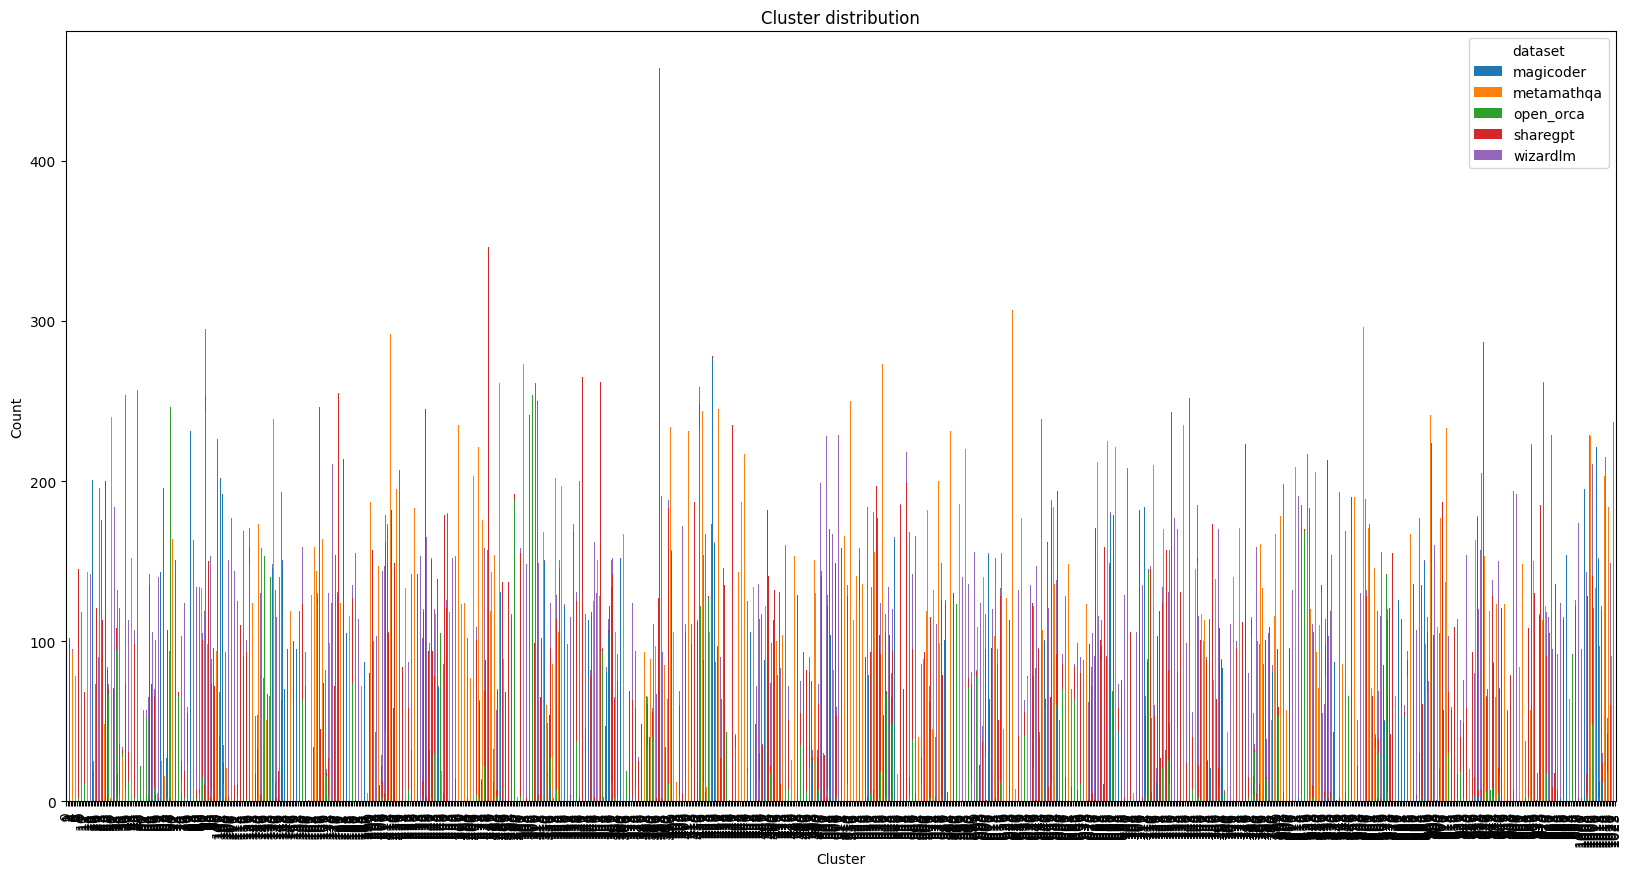

In [ ]:
# plot the dataset distribution across the cluster
distances, indices = kmeans.index.search(embeddings, 1)
indices = indices.flatten()

dataset_df = dataset.to_pandas()
dataset_df['cluster'] = indices

# plot the dataset distribution across the cluster
fig, ax = plt.subplots(figsize=(20, 10))
# with the cluster number as the x axis, the count of each dataset within the cluster as the y axis, and the color as the dataset name, stacked bar plot
dataset_df = dataset_df.groupby(['cluster', 'dataset']).size().unstack(fill_value=0)
dataset_df.plot(kind='bar', stacked=True, ax=ax)
plt.xlabel('Cluster')
plt.ylabel('Count')
plt.title('Cluster distribution')
plt.show()

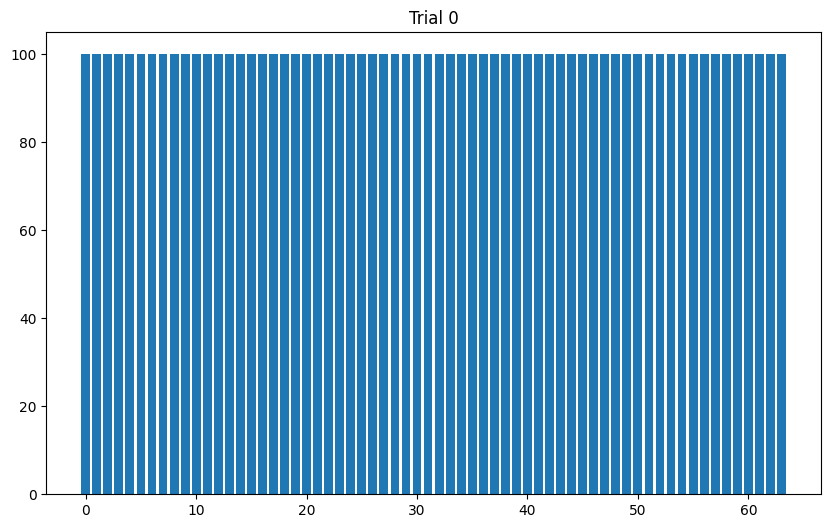

IndexError: index 6261 is out of bounds for axis 0 with size 6250

In [ ]:
from collections import Counter, defaultdict
distances, indices = kmeans.index.search(embeddings, 1)
indices = indices.flatten()
# sample 100 point from each cluster and plot them in 2D with legend
sampled_indices = {i : np.array([], dtype=np.int64) for i in range(K)}
cluster2scores = {}
clusters2indices = {i : np.where(indices == i)[0] for i in range(K)}
clusters2weights = np.ones(K) / K

select_size = 100
trial = 5
for t in range(trial):
    cluster2scores = {}
    assigned_size = np.ceil(clusters2weights * (select_size * K)).astype(int)
    # plot the assigned_size with x axis as cluster index
    fig, ax = plt.subplots(figsize=(10, 6))
    plt.bar(range(K), assigned_size)
    # with title as the current trial
    plt.title(f"Trial {t}")
    plt.show()

    for i in range(K):
        indices_i = clusters2indices[i]
        scores_i = eval_scores[indices_i]
        p = safe_softmax(scores_i)
        size = min(assigned_size[i], len(indices_i))
        indices_i_sampled = np.random.choice(indices_i, size=size, p=p, replace=False)
        sampled_indices[i] = np.concatenate([sampled_indices[i], indices_i_sampled])
        # cluster2scores[i] = eval_scores[sampled_indices[i]] / (len(sampled_indices[i]))
        cluster2scores[i] = eval_scores[sampled_indices[i]]
        
        clusters2weights[i] = np.sum(cluster2scores[i])
        clusters2indices[i] = np.setdiff1d(clusters2indices[i], indices_i_sampled)
        print(f"Cluster {i} score: {cluster2scores[i]}")
    clusters2weights /= np.sum(clusters2weights)
    # clusters2weights = safe_softmax(clusters2weights)

    # plot the distribution of cluster2scores with x axis as cluster index, y axis as the score using boxplot
    fig, ax = plt.subplots(figsize=(15, 8))
    plt.boxplot([cluster2scores[i] for i in range(K)])
    
    plt.title(f"Trial {t}")
    plt.show()

### Clustering (Check indices belong dataset)

In [ ]:
from collections import Counter, defaultdict
import pickle as pkl
indices2datasetdist = {}
for indices_name, path in indices_path.items():
    path = path.replace('.pkl', '_norm.pkl')
    with open(path, 'rb') as f:
        indices = pkl.load(f)['indices']
        indices2datasetdist[indices_name] = Counter(dataset.select(indices)['dataset'])

indices2datasetdist

{'random': Counter({'metamathqa': 1530,
          'sharegpt': 1506,
          'wizardlm': 1463,
          'magicoder': 1037,
          'open_orca': 714}),
 'KMeansRandom_1024': Counter({'sharegpt': 1628,
          'wizardlm': 1625,
          'metamathqa': 1391,
          'magicoder': 901,
          'open_orca': 522}),
 'KMeansRandom_64': Counter({'wizardlm': 2304,
          'sharegpt': 1633,
          'magicoder': 1210,
          'metamathqa': 775,
          'open_orca': 286}),
 'Deita': Counter({'wizardlm': 6009, 'magicoder': 138, 'sharegpt': 103}),
 'KMeansDynamic': Counter({'wizardlm': 4935,
          'sharegpt': 761,
          'magicoder': 717,
          'metamathqa': 222,
          'open_orca': 70}),
 'KMeansRandom': Counter({'sharegpt': 1595,
          'wizardlm': 1416,
          'metamathqa': 1393,
          'magicoder': 909,
          'open_orca': 754})}

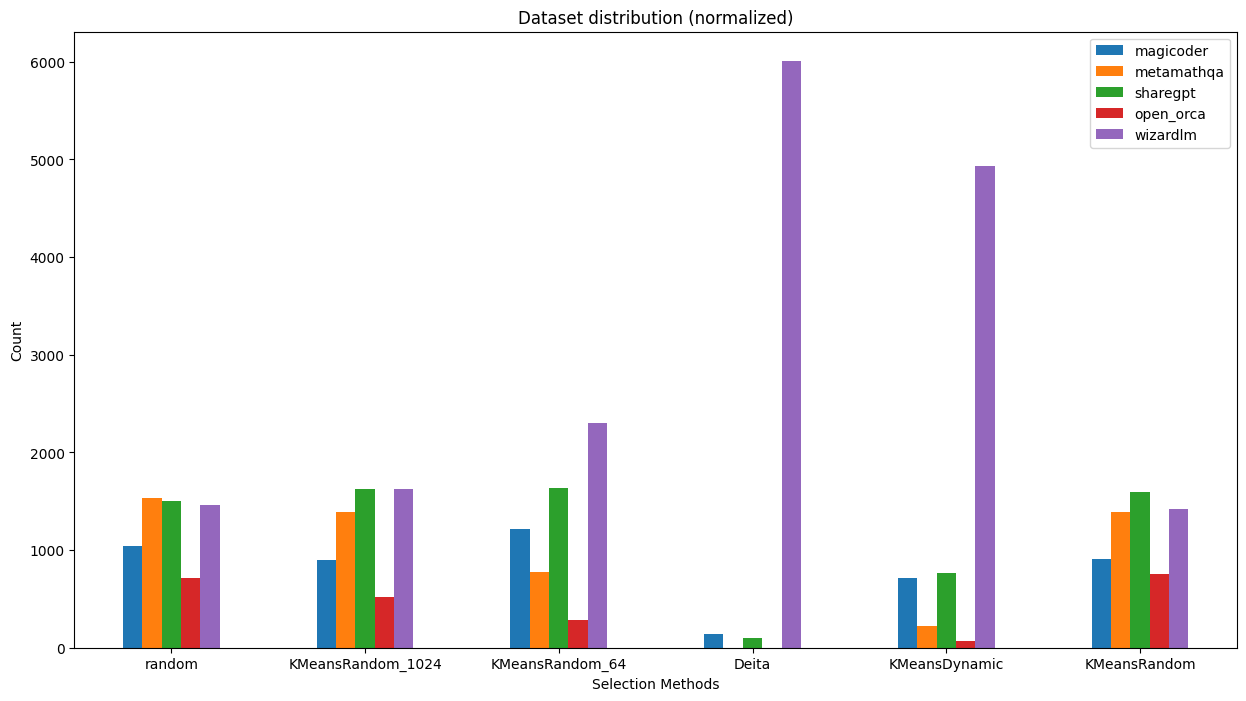

In [ ]:
# plot the distribution of dataset among each indices, with indices name as x axis, and the count of each dataset as y axis, dataset as different color, with each bar next to each other, no stacking
fig, ax = plt.subplots(figsize=(15, 8))
df = pd.DataFrame(indices2datasetdist).fillna(0).T
df.plot(kind='bar', stacked=False, ax=ax)
# rotate the x axis label
plt.xticks(rotation=0)
plt.xlabel('Selection Methods')
plt.ylabel('Count')
plt.title('Dataset distribution (normalized)')
plt.show()

In [ ]:
eval_scores = np.array(scores, dtype=np.int64)
eval_scores = eval_scores[:len(dataset)]

dataset = dataset.add_column('eval_score', eval_scores)
dataset

In [ ]:
# plot the distribution of scores across different datasets
fig, ax = plt.subplots(figsize=(15, 8))
dataset2scores = defaultdict(list)
dataset_indices = dataset['dataset']
dataset_names = list(set(dataset['dataset']))
for dataset_name in dataset_names:
    filtered_by_dataset = dataset.filter(lambda x: x['dataset'] == dataset_name)
    dataset2scores[dataset_name] = filtered_by_dataset['eval_score']
# plot boxplot with x axis as dataset name, y axis as scores
plt.boxplot(dataset2scores.values(), labels=dataset2scores.keys())
plt.title('Scores across different datasets')
plt.legend()
plt.show()

In [ ]:
dataset = dataset.map(lambda x: {'norm_scores': x['eval_score'] / len(x['messages'])})

fig, ax = plt.subplots(figsize=(15, 8))
dataset2scores = defaultdict(list)
dataset_indices = dataset['dataset']
dataset_names = list(set(dataset['dataset']))
for dataset_name in dataset_names:
    filtered_by_dataset = dataset.filter(lambda x: x['dataset'] == dataset_name)
    dataset2scores[dataset_name] = filtered_by_dataset['norm_scores']
# plot boxplot with x axis as dataset name, y axis as scores
plt.boxplot(dataset2scores.values(), labels=dataset2scores.keys())
plt.title('Norm Scores across different datasets')
plt.legend()
plt.show()

In [ ]:
norm_scores = dataset['norm_scores']
# save the norm_scores to the file
with open('/mnt/data/data-selection/data/processed/cohere/norm_scores.jsonl', 'w') as f:
    for score in norm_scores:
        f.write(json.dumps({'eval_score': score}) + '\n')

In [ ]:
# would deita score higher for wizardlm than sharegpt
sharegpt = load_dataset('json',
                        data_files='/mnt/data/data-selection/data/processed/sharegpt/sharegpt_data.jsonl')['train']
wizardlm = load_dataset('json',
                        data_files='/mnt/data/data-selection/data/processed/wizardlm_old/wizardlm_data.jsonl')['train']

sharegpt = sharegpt.map(lambda x: {'ori_id': x['id'].split('_')[1]})
wizardlm = wizardlm.map(lambda x: {'ori_id': x['id'].split('_')[1]})

In [ ]:
# sample 500 unique ori_id from sharegpt
sharegpt_ori_ids = np.array(sharegpt['ori_id'])
unique_sharegpt_ori_ids = np.unique(sharegpt_ori_ids)
sampled_sharegpt_ori_ids = np.random.choice(unique_sharegpt_ori_ids, 1000, replace=False)

# filter the sharegpt and wizardlm with the sampled ori_id
filtered_sharegpt = sharegpt.filter(lambda x: x['ori_id'] in sampled_sharegpt_ori_ids)
filtered_wizardlm = wizardlm.filter(lambda x: x['ori_id'] in sampled_sharegpt_ori_ids)

In [ ]:
output_path = '/mnt/data/data-selection/data/processed/sharegpt_wizardlm'
if not os.path.exists(output_path):
    os.makedirs(output_path)

with open(os.path.join(output_path, 'sharegpt_wizardlm_data.jsonl'), 'w') as f:
    for example in filtered_sharegpt:
        f.write(json.dumps(example) + '\n')
    for example in filtered_wizardlm:
        f.write(json.dumps(example) + '\n')

In [ ]:
data_path = '/mnt/data/data-selection/data/processed/sharegpt_wizardlm/sharegpt_wizardlm_data.jsonl'
scores_path = '/mnt/data/data-selection/data/processed/sharegpt_wizardlm/scores.jsonl'
reward_scores_path = '/mnt/data/data-selection/data/processed/sharegpt_wizardlm/reward_scores.jsonl'

with open(scores_path, "r") as f:
    lines = f.readlines()
scores = [json.loads(line)['eval_score'] for line in lines]
eval_scores = np.array(scores, dtype=np.int64)

with open(reward_scores_path, "r") as f:
    lines = f.readlines()
reward_scores = [json.loads(line)['reward_score'] for line in lines]
reward_scores = np.array(reward_scores, dtype=np.float32)

data = load_dataset('json', data_files=data_path)['train']
eval_scores = eval_scores[:len(data)]

In [ ]:
data = data.add_column('eval_score', eval_scores)
data = data.add_column('reward_score', reward_scores)
data = data.map(lambda x: {'eval_score': x['eval_score'] / (len(x['messages']) // 2)})
data = data.map(lambda x: {'reward_score': x['reward_score'] / (len(x['messages']) // 2)})
data

In [ ]:
data[1]

In [ ]:
# sample three ori_id and plot the distribution of scores among datasets
unique_sharegpt_ori_ids = list(set(data['ori_id']))
sampled_ori_ids = np.random.choice(unique_sharegpt_ori_ids, 15, replace=False)
sampled_data = data.filter(lambda x: x['ori_id'] in sampled_ori_ids)

In [ ]:
df = sampled_data.to_pandas()
# group by ori_id and add a new column as the mean of eval_score across datasets: "{'sharegpt': [1, 2, 3], 'wizardlm': [4, 5, 6]}"
df = df.groupby('ori_id').agg({'eval_score': list , 'reward_score': list}).reset_index()
df['eval_score'] = df['eval_score'].apply(lambda x: {d: np.mean(x) for d, x in zip(['sharegpt', 'wizardlm'], x)})
df['reward_score'] = df['reward_score'].apply(lambda x: {d: np.mean(x) for d, x in zip(['sharegpt', 'wizardlm'], x)})
df

In [ ]:
# filter the one that ori_id == "3ktwkYA"
test_df = data.filter(lambda x: x['ori_id'] == "S2qCmdv").to_pandas()
# test_df.iloc[0]['messages']
test_df

In [ ]:
def encode_reward_message(messages):
    final_message = ""
    for message in messages:
        if message['role'] == 'system':
            final_message += "###System: " + message['content'] + " "
        elif message['role'] == 'user':
            final_message += "###Human: " + message['content'] + " "
        elif message['role'] == 'assistant':
            final_message += "###Assistant: " + message['content'] + " "
    return final_message
test_df['final_message'] = test_df['messages'].apply(encode_reward_message)

print(test_df.iloc[0]['final_message'].replace('\n', ' '))
print(test_df.iloc[1]['final_message'].replace('\n', ' '))
test_df

### Clustering (Check the distribution across clusters)

In [1]:
import faiss
K = 64
embeddings.shape
d = embeddings.shape[1]
index = faiss.IndexFlatL2(d)
index.add(embeddings)

kmeans = faiss.Kmeans(d, K, niter=300, verbose=True, nredo=5, gpu=True)
kmeans.train(embeddings)

NameError: name 'embeddings' is not defined

In [ ]:
data_path = '/mnt/data/data-selection/data/processed/cohere/cohere_data.jsonl'
scores_path = '/mnt/data/data-selection/data/processed/cohere/scores.jsonl'

with open(scores_path, "r") as f:
    lines = f.readlines()
scores = [json.loads(line)['eval_score'] for line in lines]
eval_scores = np.array(scores, dtype=np.int64)

data = load_dataset('json', data_files=data_path)['train']
eval_scores = eval_scores[:len(data)]
data = data.add_column('eval_score', eval_scores)
data

In [ ]:
data_df = data.to_pandas()
# filter those magicoder 
data_df = data_df[data_df['dataset'] == 'sharegpt']
sample_df = data_df.sample(5)

sample_df['final_message'] = sample_df['messages'].apply(encode_reward_message)
print(sample_df['final_message'].iloc[0].replace('\n', ' '))
print(sample_df['final_message'].iloc[1].replace('\n', ' '))
print()

In [ ]:
# escape all "\'" and "\"" in the final_message
sample_df['final_message'].iloc[0].replace('\n', ' ').replace('\'', '\\\'').replace('\"', '\\\"')

In [ ]:
input_text = '###Human: You are tasked with creating a program that manages the status of ID card processing for a company. The program should handle the storage of the file path for the back side of the ID card and the status of the processing.  You need to create a class `IDCardProcessing` with the following specifications: - A private member variable `back_side_of_id_card_path` of type string to store the file path for the back side of the ID card. - A private member variable `status` of type boolean to store the processing status, where `true` indicates processed and `false` indicates pending.  Implement the following methods: 1. `setBackSidePath(path: string)`: A method to set the file path for the back side of the ID card. 2. `setStatus(processed: boolean)`: A method to set the processing status. 3. `getBackSidePath(): string`: A method to retrieve the file path for the back side of the ID card. 4. `getStatus(): boolean`: A method to retrieve the processing status.  Ensure that the class provides appropriate encapsulation and validation for the member variables.  Write a program to demonstrate the usage of the `IDCardProcessing` class by setting the file path, updating the processing status, and retrieving the information. ###Assistant: ```typescript class IDCardProcessing {     private back_side_of_id_card_path: string;     private status: boolean;      public setBackSidePath(path: string): void {         this.back_side_of_id_card_path = path;     }      public setStatus(processed: boolean): void {         this.status = processed;     }      public getBackSidePath(): string {         return this.back_side_of_id_card_path;     }      public getStatus(): boolean {         return this.status;     } }  // Demonstration const idCard = new IDCardProcessing(); idCard.setBackSidePath("/path/to/back_side_id_card.jpg"); idCard.setStatus(true);  console.log("ID Card Back Side Path:", idCard.getBackSidePath()); console.log("ID Card Processing Status:", idCard.getStatus()); ```  In this solution, the `IDCardProcessing` class encapsulates the file path and processing status, providing methods to set and retrieve the information. The demonstration at the end showcases the usage of the class by setting the file path, updating the processing status, and retrieving the information. '
input_text.split('###')[1]

In [ ]:
from collections import Counter
from tqdm import trange
distances, indices = kmeans.index.search(embeddings, 1)

# flatten indices
indices = indices.reshape(-1)
dataset_dist = {}
cluster2score= {}
for i in trange(K):
    indices_i = np.where(indices == i)[0]
    scores_i = data.select(indices_i)
    dataset_dist[i] = Counter(scores_i['dataset'])
    cluster2score[i] = np.mean(scores_i['eval_score'])

In [ ]:
# normalize by the total number of data in each dataset
total_number = {
    dataset: len(data.filter(lambda x: x['dataset'] == dataset)) for dataset in set(data['dataset'])
}
for i in range(K):
    for dataset in dataset_dist[i]:
        dataset_dist[i][dataset] /= total_number[dataset]

# plot the distribution of dataset_dist
import pandas as pd
df = pd.DataFrame(dataset_dist)
df

In [ ]:
# plot the distribution of dataset_dist with x axis as cluster index, y axis as the percentage of each dataset
fig, ax = plt.subplots(figsize=(15, 8))
df.T.plot(kind='bar', stacked=True, ax=ax)
ax1 = ax.twinx()
# plot the score of each cluster above the bar as line plot
ax1.plot(cluster2score.values(), color='black')

/mnt/data/selection/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/mnt/data/selection/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)
/mnt/data/selection/lib/python3.10/site-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


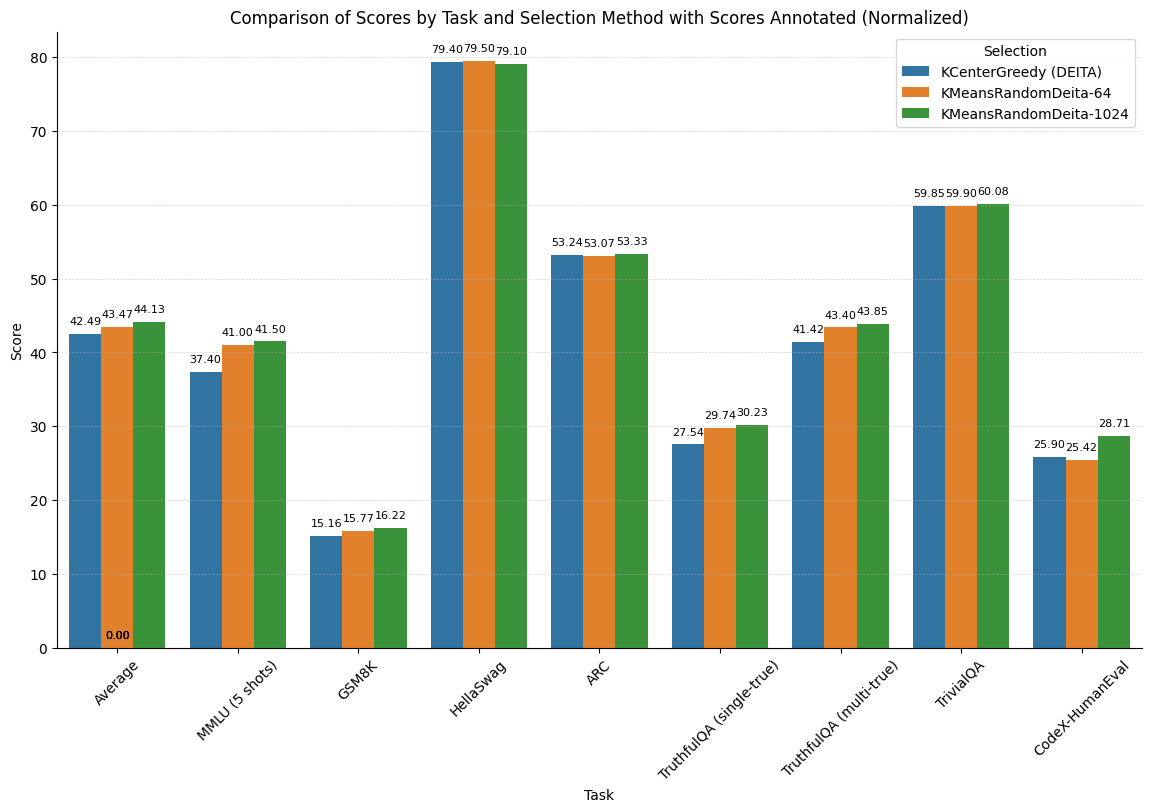

In [ ]:
# It seems that the code execution environment has been reset.
# I will re-import the necessary libraries and re-define the data to re-plot the graph.

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from io import StringIO

temp = """
KMeansRandom-1024,46.73,43.1,16.22,79.1,53.33,30.6,45.1,59.64,28.65
Random,,43.3,18.5,78.65,53.07,33.9,49.71,56.39,29.92

"""
# Redefining the data as it was lost due to the reset
new_data_text = """
Selection,Average,MMLU (5 shots),GSM8K,HellaSwag,ARC,TruthfulQA (single-true),TruthfulQA (multi-true),TrivialQA,CodeX-HumanEval
KCenterGreedy (DEITA),44.86,37.4,15.16,79.4,53.24,27.54,41.42,59.85,25.9
KMeansRandomDeita-64,46.05,41,15.77,79.5,53.07,29.74,43.4,59.9,25.42
KMeansRandomDeita-1024,46.33,41.5,16.22,79.1,53.33,30.23,43.85,60.08,28.71
"""

# Read the string data into a DataFrame
new_df = pd.read_csv(StringIO(new_data_text))

# fill the average column with the mean of the rest of the columns
new_df['Average'] = new_df.iloc[:, 2:].mean(axis=1)
# Prepare the data for plotting by "melting" it
new_df_melted = new_df.melt(id_vars='Selection', var_name='Task', value_name='Score')

# Plot using seaborn with scores annotated above each bar with a smaller font size
plt.figure(figsize=(14, 8))
barplot = sns.barplot(x='Task', y='Score', hue='Selection', data=new_df_melted)

# Annotate each bar with the score with smaller font size
for p in barplot.patches:
    barplot.annotate(format(p.get_height(), '.2f'), 
                     (p.get_x() + p.get_width() / 2., p.get_height()), 
                     ha = 'center', va = 'center', 
                     xytext = (0, 9), 
                     textcoords = 'offset points', 
                     fontsize=8)

plt.title('Comparison of Scores by Task and Selection Method with Scores Annotated (Normalized)')
plt.xticks(rotation=45)
plt.ylabel('Score')
plt.xlabel('Task')
sns.despine()
# add grid
plt.grid(True, axis='y', linestyle='--', linewidth=0.5, alpha=0.5)

# Show the plot with smaller annotations
plt.show()